#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 神经网络简介

 **学习目标：**
  * 使用 TensorFlow `DNNRegressor` 类定义神经网络 (NN) 及其隐藏层
  * 训练神经网络学习数据集中的非线性规律，并实现比线性回归模型更好的效果

 在之前的练习中，我们使用合成特征来帮助模型学习非线性规律。

一组重要的非线性关系是纬度和经度的关系，但也可能存在其他非线性关系。

现在我们从之前练习中的逻辑回归任务回到标准的（线性）回归任务。也就是说，我们将直接预测 `median_house_value`。

 ## 设置

首先加载和准备数据。

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.7,2632.6,537.5,1422.6,499.4,3.9,2.0
std,2.1,2.0,12.6,2160.5,416.4,1135.9,380.0,1.9,1.2
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1458.0,296.0,786.0,279.0,2.6,1.5
50%,34.2,-118.5,29.0,2112.0,432.0,1161.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3128.2,647.0,1721.0,602.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.4,2670.1,544.1,1446.3,505.7,3.9,2.0
std,2.1,2.0,12.6,2225.8,433.5,1176.0,395.3,1.8,1.1
min,32.5,-124.3,2.0,2.0,2.0,6.0,2.0,0.5,0.2
25%,33.9,-121.8,18.0,1468.0,298.0,797.0,286.0,2.6,1.5
50%,34.3,-118.6,29.0,2172.0,438.5,1181.5,411.0,3.6,1.9
75%,37.7,-118.0,37.0,3189.2,653.0,1721.0,609.0,4.7,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,28566.0,6082.0,15.0,29.4


Training targets summary:


,median_house_value
count,12000.0
mean,208.0
std,116.8
min,15.0
25%,119.6
50%,180.1
75%,266.7
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,205.5
std,114.1
min,17.5
25%,119.0
50%,180.9
75%,261.0
max,500.0


 ## 构建神经网络

神经网络由 [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor) 类定义。

使用 **`hidden_units`** 定义神经网络的结构。`hidden_units` 参数会创建一个整数列表，其中每个整数对应一个隐藏层，表示其中的节点数。以下面的赋值为例：

`hidden_units=[3,10]`

上述赋值为神经网络指定了两个隐藏层：

* 第一个隐藏层包含 3 个节点。
* 第二个隐藏层包含 10 个节点。

如果我们想要添加更多层，可以向该列表添加更多整数。例如，`hidden_units=[10,20,30,40]` 会创建 4 个分别包含 10、20、30 和 40 个单元的隐藏层。

默认情况下，所有隐藏层都会使用 ReLu 激活函数，且是全连接层。

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

 ## 任务 1：训练神经网络模型

**调整超参数，目标是将 RMSE 降到 110 以下。**

运行以下代码块来训练神经网络模型。

我们已经知道，在使用了很多特征的线性回归练习中，110 左右的 RMSE 已经是相当不错的结果。我们将得到比它更好的结果。

在此练习中，您的任务是修改各种学习设置，以提高在验证数据上的准确率。

对于神经网络而言，过拟合是一种真正的潜在危险。您可以查看训练数据损失与验证数据损失之间的差值，以帮助判断模型是否有过拟合的趋势。如果差值开始变大，则通常可以肯定存在过拟合。

由于存在很多不同的可能设置，强烈建议您记录每次试验，以在开发流程中进行参考。

此外，获得效果出色的设置后，尝试多次运行该设置，看看结果的重复程度。由于神经网络权重通常会初始化为较小的随机值，因此每次运行结果应该存在差异。



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training model...
RMSE (on training data):
  period 00 : 165.78
  period 01 : 165.94
  period 02 : 160.51
  period 03 : 179.13
  period 04 : 145.70
  period 05 : 135.72
  period 06 : 158.64
  period 07 : 156.30
  period 08 : 123.74
  period 09 : 213.85
Model training finished.
Final RMSE (on training data):   213.85
Final RMSE (on validation data): 219.30


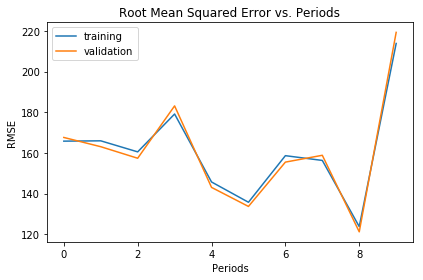

In [9]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 149.48
  period 01 : 197.81
  period 02 : 135.49
  period 03 : 155.37
  period 04 : 155.77
  period 05 : 143.24
  period 06 : 127.61
  period 07 : 139.14
  period 08 : 119.44
  period 09 : 112.65
Model training finished.
Final RMSE (on training data):   112.65
Final RMSE (on validation data): 111.45


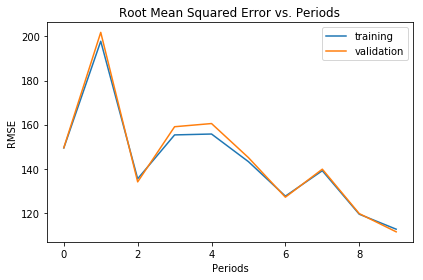

In [10]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=1000,
    batch_size=10,
    hidden_units=[10, 6, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 230.10
  period 01 : 221.54
  period 02 : 213.11
  period 03 : 204.82
  period 04 : 196.69
  period 05 : 188.73
  period 06 : 180.98
  period 07 : 173.46
  period 08 : 166.20
  period 09 : 159.24
Model training finished.
Final RMSE (on training data):   159.24
Final RMSE (on validation data): 155.59


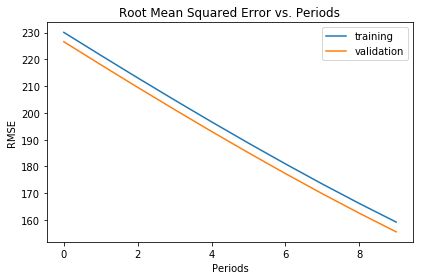

In [11]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=2000,
    batch_size=10,
    hidden_units=[10, 8, 6, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 212.90
  period 01 : 188.53
  period 02 : 166.02
  period 03 : 146.22
  period 04 : 130.72
  period 05 : 122.35
  period 06 : 119.00
  period 07 : 117.40
  period 08 : 116.91
  period 09 : 116.76
Model training finished.
Final RMSE (on training data):   116.76
Final RMSE (on validation data): 114.09


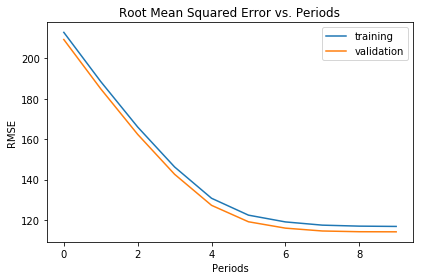

In [12]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.03,
    steps=2000,
    batch_size=10,
    hidden_units=[10, 6, 4, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 197.09
  period 01 : 159.58
  period 02 : 131.40
  period 03 : 119.15
  period 04 : 116.98
  period 05 : 116.80
  period 06 : 116.79
  period 07 : 116.76
  period 08 : 116.75
  period 09 : 116.76
Model training finished.
Final RMSE (on training data):   116.76
Final RMSE (on validation data): 114.15


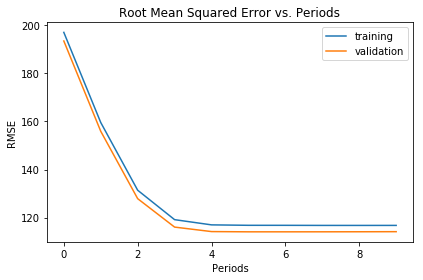

In [13]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.05,
    steps=2000,
    batch_size=10,
    hidden_units=[10, 6, 4, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 194.90
  period 01 : 192.65
  period 02 : 189.79
  period 03 : 207.99
  period 04 : 160.66
  period 05 : 172.10
  period 06 : 145.28
  period 07 : 222.96
  period 08 : 144.14
  period 09 : 155.73
Model training finished.
Final RMSE (on training data):   155.73
Final RMSE (on validation data): 152.89


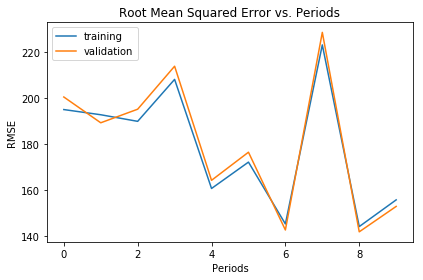

In [14]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.05,
    steps=2000,
    batch_size=20,
    hidden_units=[10, 6, 4, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 191.00
  period 01 : 453.89
  period 02 : 812.16
  period 03 : 323.33
  period 04 : 229.46
  period 05 : 184.00
  period 06 : 194.68
  period 07 : 329.09
  period 08 : 173.16
  period 09 : 254.21
Model training finished.
Final RMSE (on training data):   254.21
Final RMSE (on validation data): 261.45


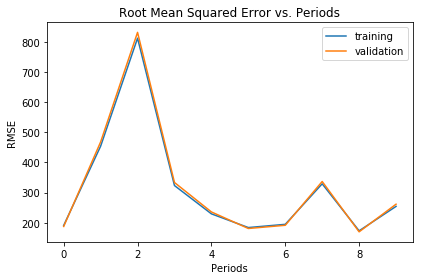

In [15]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.1,
    steps=2000,
    batch_size=10,
    hidden_units=[10, 6, 4, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 177.00
  period 01 : 130.66
  period 02 : 117.27
  period 03 : 116.81
  period 04 : 116.84
  period 05 : 116.85
  period 06 : 116.77
  period 07 : 116.75
  period 08 : 116.82
  period 09 : 116.87
Model training finished.
Final RMSE (on training data):   116.87
Final RMSE (on validation data): 114.12


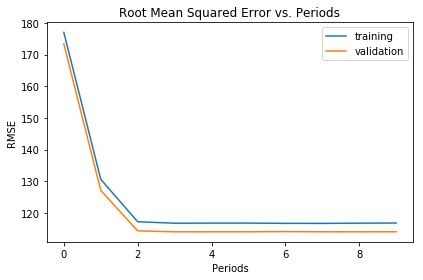

In [16]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.05,
    steps=3000,
    batch_size=10,
    hidden_units=[10, 6, 4, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 197.52
  period 01 : 159.96
  period 02 : 130.99
  period 03 : 119.20
  period 04 : 116.93
  period 05 : 116.77
  period 06 : 116.76
  period 07 : 116.79
  period 08 : 116.79
  period 09 : 116.77
Model training finished.
Final RMSE (on training data):   116.77
Final RMSE (on validation data): 114.09


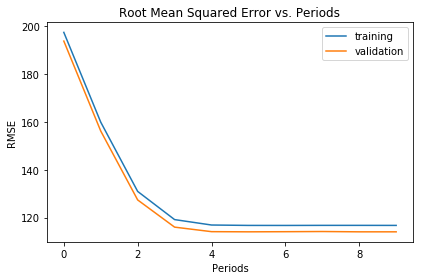

In [17]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.05,
    steps=2000,
    batch_size=10,
    hidden_units=[10, 8, 8, 4],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 144.43
  period 01 : 143.63
  period 02 : 174.71
  period 03 : 173.82
  period 04 : 146.33
  period 05 : 130.65
  period 06 : 111.81
  period 07 : 124.04
  period 08 : 121.92
  period 09 : 119.25
Model training finished.
Final RMSE (on training data):   119.25
Final RMSE (on validation data): 117.36


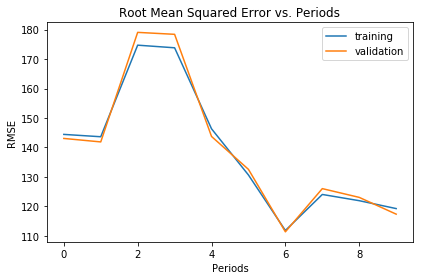

In [18]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=1000,
    batch_size=10,
    hidden_units=[6, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 208.27
  period 01 : 153.67
  period 02 : 321.90
  period 03 : 125.96
  period 04 : 174.60
  period 05 : 214.47
  period 06 : 174.77
  period 07 : 187.92
  period 08 : 132.83
  period 09 : 124.47
Model training finished.
Final RMSE (on training data):   124.47
Final RMSE (on validation data): 121.56


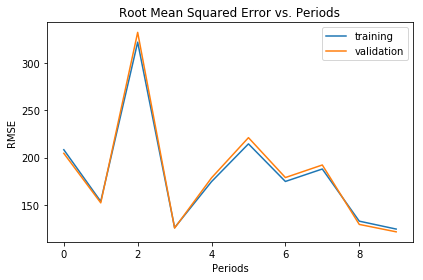

In [19]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.03,
    steps=1000,
    batch_size=10,
    hidden_units=[6, ],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 191.71
  period 01 : 196.90
  period 02 : 170.94
  period 03 : 234.69
  period 04 : 142.42
  period 05 : 157.44
  period 06 : 160.03
  period 07 : 173.61
  period 08 : 148.25
  period 09 : 126.57
Model training finished.
Final RMSE (on training data):   126.57
Final RMSE (on validation data): 124.62


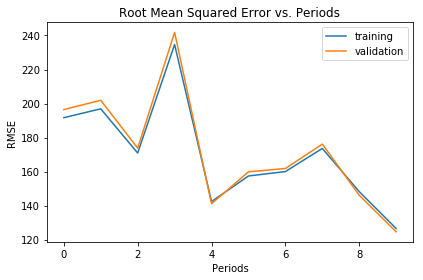

In [20]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=1000,
    batch_size=10,
    hidden_units=[10, 6, 4, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 212.02
  period 01 : 204.77
  period 02 : 156.88
  period 03 : 245.68
  period 04 : 180.85
  period 05 : 146.47
  period 06 : 169.44
  period 07 : 139.40
  period 08 : 150.87
  period 09 : 137.73
Model training finished.
Final RMSE (on training data):   137.73
Final RMSE (on validation data): 139.52


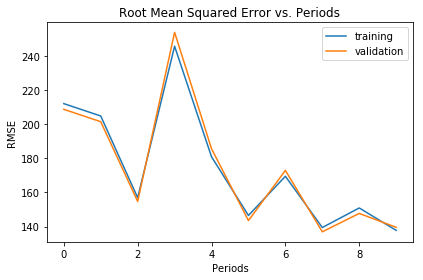

In [21]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.03,
    steps=1000,
    batch_size=10,
    hidden_units=[4, ],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 154.39
  period 01 : 138.73
  period 02 : 126.16
  period 03 : 115.18
  period 04 : 114.23
  period 05 : 108.80
  period 06 : 112.09
  period 07 : 111.48
  period 08 : 109.13
  period 09 : 107.49
Model training finished.
Final RMSE (on training data):   107.49
Final RMSE (on validation data): 108.60


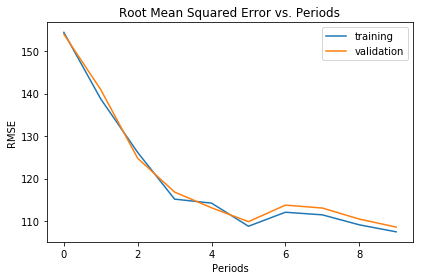

In [33]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.003,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 8, 8, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### 解决方案

点击下方即可查看可能的解决方案

 **注意**：在本次练习中，参数的选择有点随意。我们尝试了越来越复杂的组合，并进行了较长时间的训练，直到误差降到目标之下。这决不是最佳组合；其他组合可能会获得更低的 RMSE。如果您的目标是找到可以产生最小误差的模型，那么您需要使用更严格的流程，例如参数搜索。

Training model...
RMSE (on training data):
  period 00 : 173.64
  period 01 : 168.81
  period 02 : 165.83
  period 03 : 156.02
  period 04 : 148.68
  period 05 : 142.30
  period 06 : 132.74
  period 07 : 121.47
  period 08 : 114.37
  period 09 : 115.86
Model training finished.
Final RMSE (on training data):   115.86
Final RMSE (on validation data): 117.60


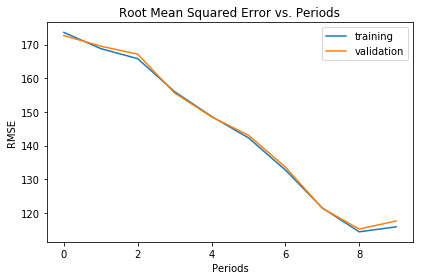

In [29]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 任务 2：用测试数据进行评估

**确认您的验证效果结果经受得住测试数据的检验。**

获得满意的模型后，用测试数据评估该模型，以与验证效果进行比较。

提示：测试数据集位于[此处](https://download.mlcc.google.cn/mledu-datasets/california_housing_test.csv)。

In [36]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_test.csv", sep=",")

# YOUR CODE HERE
test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)
predict_testing_input_fn = lambda: my_input_fn(test_examples,
                                              test_targets["median_house_value"],
                                              num_epochs=1,
                                              shuffle=False)
test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (no test data): %0.2f" % root_mean_squared_error)

Final RMSE (no test data): 107.50


 ### 解决方案

点击下方即可查看可能的解决方案。

 与顶部代码类似，我们只需加载合适的数据文件、对其进行预处理并调用预测和 mean_squared_error 即可。

请注意，由于我们会使用所有记录，因此无需对测试数据进行随机化处理。

In [0]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["median_house_value"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)